# Exercise 3.9
Create your own road network: a grid-like city with 10\*10 intersections
* Use OSMnx for that, i.e., create appropriate lines and points to represent edges and nodes
* Save it in a proper format
* Submit a (well documented) notebook.

## Importing the Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

import urllib.request

import osmnx as ox

#to tessellate and plot tessellations
from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

#for the Voronoi Tessellation
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import *

## Loading a small graph

In [2]:
G = ox.graph_from_address('Polo Fibonacci, Pisa, Italy', dist=100)

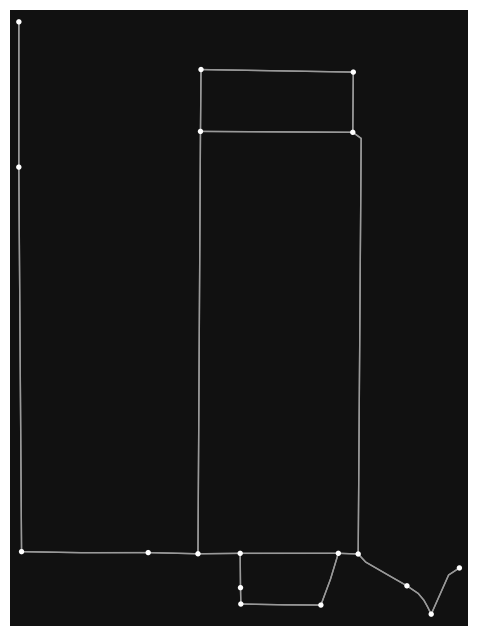

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [3]:
ox.plot_graph(G)

In [ ]:
map_network = ox.plot_graph_folium(G)
map_network

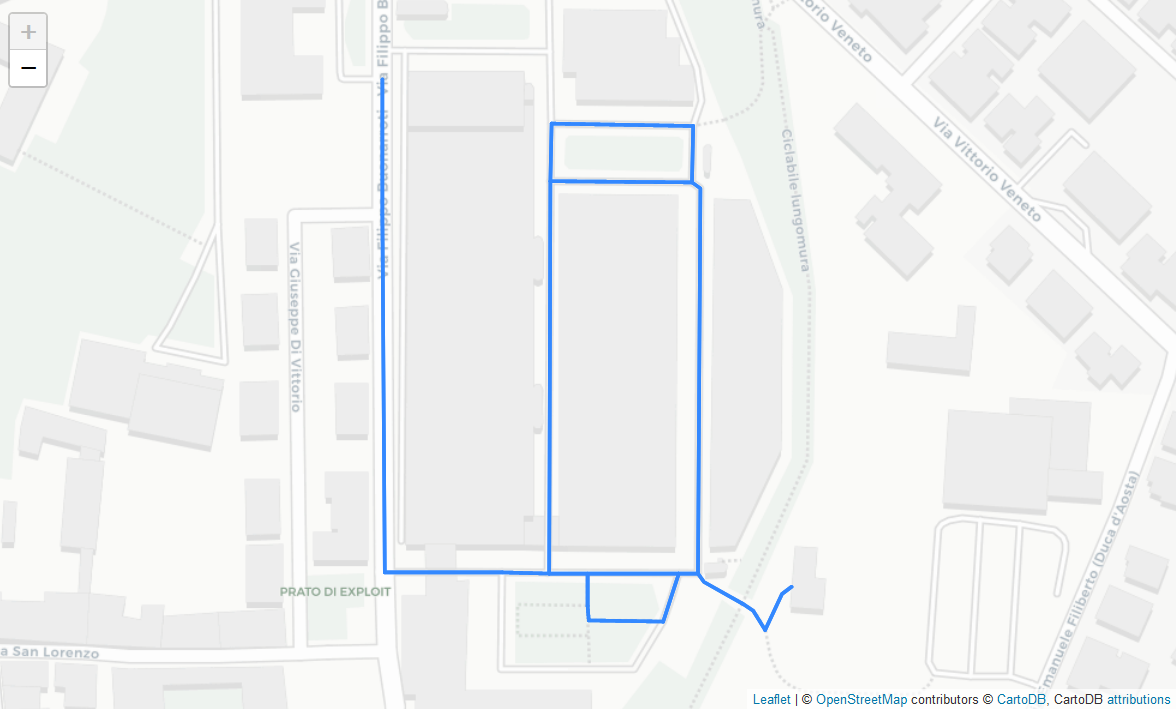

## Saving the Graph to a file

In [5]:
file_name = 'Fibo.osm'
ox.io.save_graphml(G, 'Fibo.osm')

## Opening the file to see how it is structured

In [6]:
with open(file_name, 'r') as osm:
    xml = osm.readlines()

In [7]:
#xml

## Store the head and the tail

In [8]:
first_node_idx = xml.index('<node id="246382226">\n')

In [9]:
head = xml[:first_node_idx]
head

["<?xml version='1.0' encoding='utf-8'?>\n",
 '<graphml xmlns="http://graphml.graphdrawing.org/xmlns" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd"><key id="d17" for="edge" attr.name="access" attr.type="string"/>\n',
 '<key id="d16" for="edge" attr.name="geometry" attr.type="string"/>\n',
 '<key id="d15" for="edge" attr.name="tunnel" attr.type="string"/>\n',
 '<key id="d14" for="edge" attr.name="service" attr.type="string"/>\n',
 '<key id="d13" for="edge" attr.name="length" attr.type="string"/>\n',
 '<key id="d12" for="edge" attr.name="reversed" attr.type="string"/>\n',
 '<key id="d11" for="edge" attr.name="maxspeed" attr.type="string"/>\n',
 '<key id="d10" for="edge" attr.name="highway" attr.type="string"/>\n',
 '<key id="d9" for="edge" attr.name="name" attr.type="string"/>\n',
 '<key id="d8" for="edge" attr.name="oneway" attr.type="string"/>\n',
 '<key id="d7" for=

In [10]:
tail = [xml[-1]]
tail

['</graph></graphml>']

## Node Structure

This is just a reminder for me, the <b> Node Structure </b>: <br>
With d6 = 3:
```
 '<node id="246382226">\n',
 '  <data key="d4">43.7211457</data>\n',
 '  <data key="d5">10.4073397</data>\n',
 '  <data key="d6">3</data>\n',
 '</node>\n',
 ```
With d6 = 1:
```
 '<node id="5258131752">\n',
 '  <data key="d4">43.7199421</data>\n',
 '  <data key="d5">10.4091703</data>\n',
 '  <data key="d6">1</data>\n',
 '</node>\n',
 ```

## Understanding d6
I will plot the point on the network to try to understand what it means

In [11]:
d6eq3 = 43.7211457, 10.4073397
d6eq1 = 43.7199421, 10.4091703

In [ ]:
folium.Marker(d6eq3, popup = 'D6 = 3').add_to(map_network)
folium.Marker(d6eq1, popup = 'D6 = 1', icon=folium.Icon(color='red')).add_to(map_network)
map_network

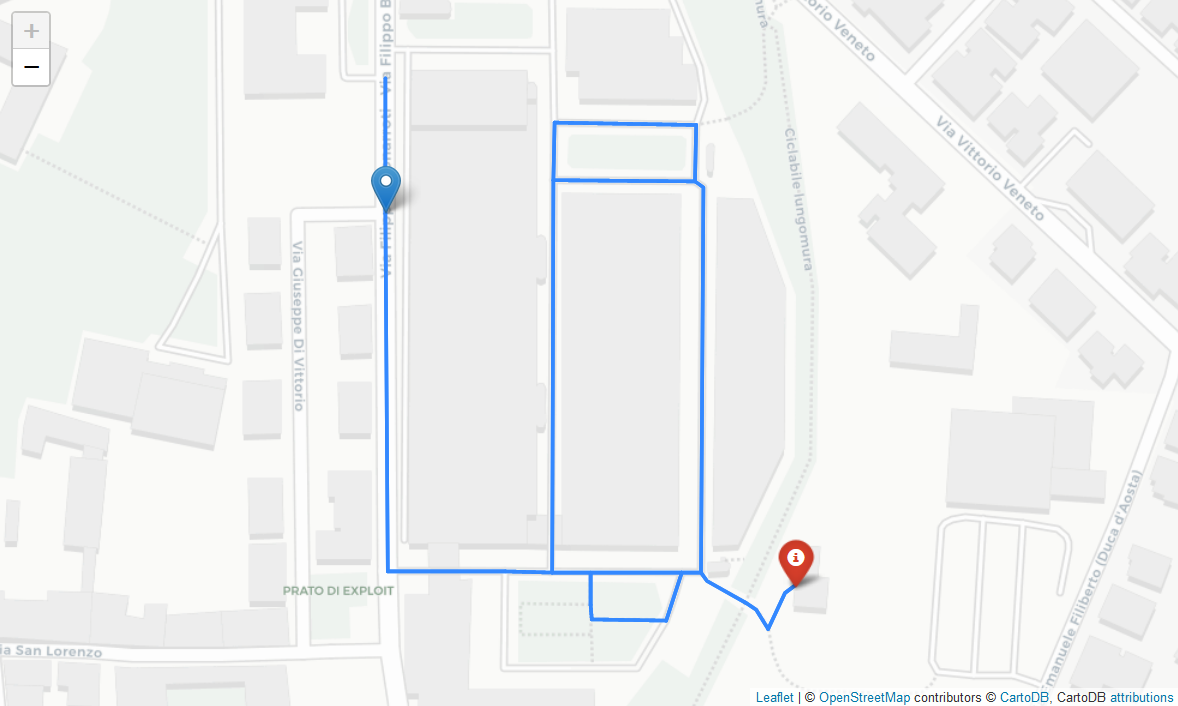

## Create a node
d6 as shown in the plot probably indicates the number of edges the node has

In [13]:
def create_node(node_id, lat, lon, d6):
    structure = [f'<node id="{node_id}">\n', 
                 f'  <data key="d4">{lat}</data>\n', 
                 f'  <data key="d5">{lon}</data>\n',
                 f'  <data key="d6">{d6}</data>\n',
                 '</node>\n']
    return structure

## Edge structure
This is just a reminder for me, the <b> Edge Structure </b>: <br>
```
 '<edge source="3191879267" target="4232115551" id="0">\n',
 '  <data key="d7">155325635</data>\n',
 '  <data key="d10">cycleway</data>\n',
 '  <data key="d17">permissive</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">19.573999999999998</data>\n',
 '  <data key="d16">LINESTRING (10.4087498 43.719984, 10.4087809 43.7199597, 10.4088728 43.7199213, 10.4089523 43.7198884)</data>\n',
 '</edge>\n',
```

```
 '<edge source="3191879269" target="6416484259" id="0">\n',
 '  <data key="d7">27642911</data>\n',
 '  <data key="d10">service</data>\n',
 '  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">14.097</data>\n',
 '</edge>\n',
```

Going by intuition: <br>
<b>source</b> and <b>target</b> are nodes <br>
<b>d7</b> is probably the id of the road <br>
<b>d10</b> is probably the type of road <br>
<b>d13</b> is the length ? <br>
<b>d16</b> store a possible geometry (probably when the segment is not a straight line ?)<br>

To avoid errors I will try to keep them similar to the source I have (keeping d8 and d12 False and creating only straight service driveways)


## Create a Edge

In [14]:
def create_edge(source, target, edge_id, length, line_geometry = None):
    length = math.radians(length)
    structure_head = [f'<edge source="{source}" target="{target}" id="0">\n',
                      f'  <data key="d7">{edge_id}</data>\n',
                      '  <data key="d10">service</data>\n',
                      '  <data key="d14">driveway</data>\n',
                      '  <data key="d8">False</data>\n',
                      '  <data key="d12">False</data>\n',
                      f'  <data key="d13">{length}</data>\n']
    structure_tail = ['</edge>\n']
    if line_geometry is not None:
        geom = [f'  <data key="d16">{line_geometry}</data>\n']
    else:
        geom = []
    return structure_head+geom+structure_tail

## Creating Points and Lines
I will try to create a symmetric road network (a square shape with 100 intersections and ten nodes for each side)

### Writing functions to move points around

In [15]:
import math #to use radians to add to coordinates

def sum_lat(lat_coord, meters): #add meters to offset from origina latitude coordinates
    #divided by two so that the lat isn't excessive when projected norther or souther
    #the max degree longitude is double of the max degree latitude, it was a good approximation in my opinion
    new_lat = lat_coord + math.radians(meters) / 2 
    return new_lat

def sum_lon(lon_coord, meters): #add meters to offset from origina latitude coordinates
    new_lon = lon_coord + math.radians(meters)
    return new_lon

def move_point_h(point, meters): #move point horizontally
    lat_coord = point.y
    lon_coord = point.x
    
    moved_lon = sum_lon(lon_coord, meters)
    
    return Point((moved_lon, lat_coord))

def move_point_v(point, meters): #move point vertically
    lat_coord = point.y
    lon_coord = point.x
    
    moved_lat = sum_lat(lat_coord, meters)
    
    return Point((lon_coord, moved_lat))

## Create the actual square of points

In [16]:
point = Point((0, 0))
meters = 10

#storing the extreme left-bottom vertex coordinates
start_x = point.x
start_y = point.y

point_collection = list()

for _ in range(10):
    point_collection.append(point) #store the first point
    for _ in range(9): #9 because the first point is already stored
        point = move_point_h(point, meters) #move the point horizontally
        point_collection.append(point) #store the point
    
    point = Point((start_x, point.y)) #moving back the point at the starting longitude
    point = move_point_v(point, meters) #moving the point vertically
    
#storing the extreme right-top vertex coordinates
end_x = point_collection[-1].x
end_y = point_collection[-1].y

In [ ]:
GeometryCollection(point_collection)

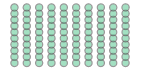

## Creating Nodes from list of Points

If the point is: <br>
On the vertex it should have 2 edges <br>
On the rest of the border it should have 3 edges <br>
On the rest of the network it should have 4 edges

In [18]:
node_list = list()
node_dict = dict() #to better call the results in the

for node_id, point in enumerate(point_collection):
    
    #storing the coordinates of the point to not extract them each time they are called
    point_x = point.x
    point_y = point.y
    
    #THROUGHT THE COORDS OF THE FIRST AND LAST POINT I CAN INFER THE BORDER AND VERTICES IF THE GRID IS AT LEAST RECTANGULAR#
    #start and end are the first and last point their coordinates were saved in the cell before 
    
    #storing the vertices conditions
    bottom_left_vert = (point_x == start_x) and (point_y == start_y)
    bottom_right_vert = (point_x == end_x) and (point_y == start_y)
    top_left_vert = (point_x == start_x) and (point_y == end_y)
    top_right_vert = (point_x == end_x) and (point_y == end_y)
    
    #storing the border conditions
    left_border = point_x == start_x
    right_border = point_x == end_x
    bottom_border = point_y == start_y
    top_border = point_y == end_y

    #if it is a vertex
    if bottom_left_vert or bottom_right_vert or top_left_vert or top_right_vert:
        d6 = 2
    #if it is on the border
    elif left_border or right_border or bottom_border or top_border:
        d6 = 3
    else:
        d6 = 4
    
    #concatenate list with new node
    node_list += create_node(node_id, lat = point_y, lon = point_x, d6 = d6)
    #add node to the dictionary to call later for building the edges
    node_dict[node_id] = {'lat' : point_y, 'lon' : point_x, 'edges' : d6}

## Visualizing the Node List

In [19]:
node_list[:15]
#node_list

['<node id="0">\n',
 '  <data key="d4">0.0</data>\n',
 '  <data key="d5">0.0</data>\n',
 '  <data key="d6">2</data>\n',
 '</node>\n',
 '<node id="1">\n',
 '  <data key="d4">0.0</data>\n',
 '  <data key="d5">0.17453292519943295</data>\n',
 '  <data key="d6">3</data>\n',
 '</node>\n',
 '<node id="2">\n',
 '  <data key="d4">0.0</data>\n',
 '  <data key="d5">0.3490658503988659</data>\n',
 '  <data key="d6">3</data>\n',
 '</node>\n']

## Creating Edges from list of Nodes

In [20]:
#to give an identifier to the edge
edge_id = 0

#to store the squared (so that it is absolute) value
#of the rounded difference (I rounded because some of the last decimals were different sometimes)
#of the latitude and longitude between real adjacent points (all the others should be the same being a symmetric grid)

sqrd_adjacent_lat = round(node_dict[0]['lat'] - node_dict[10]['lat'], 6)**2
sqrd_adjacent_lon = round(node_dict[0]['lon'] - node_dict[1]['lon'], 6)**2

edge_list = list()
#looping through all the nodes twice 
for source in node_dict.keys():
    for target in node_dict.keys():
        #storing the value of the difference between latitude and longitude
        diff_sqrd_latitude = round(node_dict[source]['lat'] - node_dict[target]['lat'], 6)**2
        diff_sqrd_longitude = round(node_dict[source]['lon'] - node_dict[target]['lon'], 6)**2
        
        #if the nodes are adjacent
        adjacent_latitude = diff_sqrd_latitude == sqrd_adjacent_lat
        adjacent_longitude = diff_sqrd_longitude == sqrd_adjacent_lon
        
        #if the nodes are on the same row or column
        same_latitude = diff_sqrd_latitude == 0
        same_longitude = diff_sqrd_longitude == 0
        
        #if they are adjacent point by latitude or longitude, 
        #to be really adjacent they should be on the same row or column respectively
        if adjacent_latitude and same_longitude or adjacent_longitude and same_latitude:
            #concatenating the list of edges created
            edge_list += create_edge(source, target, edge_id, length = meters, line_geometry = None)
            edge_id += 1

## Visualizing the Edge List

In [21]:
edge_list[:15]

['<edge source="0" target="1" id="0">\n',
 '  <data key="d7">0</data>\n',
 '  <data key="d10">service</data>\n',
 '  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">0.17453292519943295</data>\n',
 '</edge>\n',
 '<edge source="0" target="10" id="0">\n',
 '  <data key="d7">1</data>\n',
 '  <data key="d10">service</data>\n',
 '  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">0.17453292519943295</data>\n']

## Uniting the list and building the text file to save as osm

In [22]:
unite_list = head + node_list + edge_list + tail
new_file = ''.join(unite_list)

### Visualizing the head of the file

In [23]:
unite_list[:30]

["<?xml version='1.0' encoding='utf-8'?>\n",
 '<graphml xmlns="http://graphml.graphdrawing.org/xmlns" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd"><key id="d17" for="edge" attr.name="access" attr.type="string"/>\n',
 '<key id="d16" for="edge" attr.name="geometry" attr.type="string"/>\n',
 '<key id="d15" for="edge" attr.name="tunnel" attr.type="string"/>\n',
 '<key id="d14" for="edge" attr.name="service" attr.type="string"/>\n',
 '<key id="d13" for="edge" attr.name="length" attr.type="string"/>\n',
 '<key id="d12" for="edge" attr.name="reversed" attr.type="string"/>\n',
 '<key id="d11" for="edge" attr.name="maxspeed" attr.type="string"/>\n',
 '<key id="d10" for="edge" attr.name="highway" attr.type="string"/>\n',
 '<key id="d9" for="edge" attr.name="name" attr.type="string"/>\n',
 '<key id="d8" for="edge" attr.name="oneway" attr.type="string"/>\n',
 '<key id="d7" for=

### Visualizing the tail of the file

In [24]:
unite_list[-30:]

['  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">0.17453292519943295</data>\n',
 '</edge>\n',
 '<edge source="98" target="99" id="0">\n',
 '  <data key="d7">357</data>\n',
 '  <data key="d10">service</data>\n',
 '  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">0.17453292519943295</data>\n',
 '</edge>\n',
 '<edge source="99" target="89" id="0">\n',
 '  <data key="d7">358</data>\n',
 '  <data key="d10">service</data>\n',
 '  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '  <data key="d13">0.17453292519943295</data>\n',
 '</edge>\n',
 '<edge source="99" target="98" id="0">\n',
 '  <data key="d7">359</data>\n',
 '  <data key="d10">service</data>\n',
 '  <data key="d14">driveway</data>\n',
 '  <data key="d8">False</data>\n',
 '  <data key="d12">False</data>\n',
 '

## Saving the custom network as '.osm'

In [25]:
with open('my_network.osm', 'w') as osm:
    osm.write(new_file)

## Loading the custom network again on OSMnx to visualize it

In [26]:
G = ox.io.load_graphml('my_network.osm')

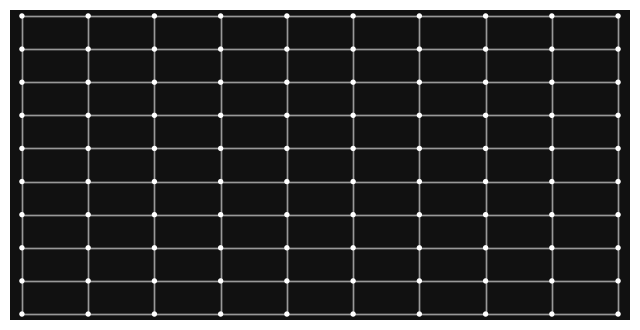

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [29]:
# plotting the raw network
ox.plot_graph(G)

In [ ]:
# plotting the network on OSM (it should be around Null Island)
ox.plot_graph_folium(G)

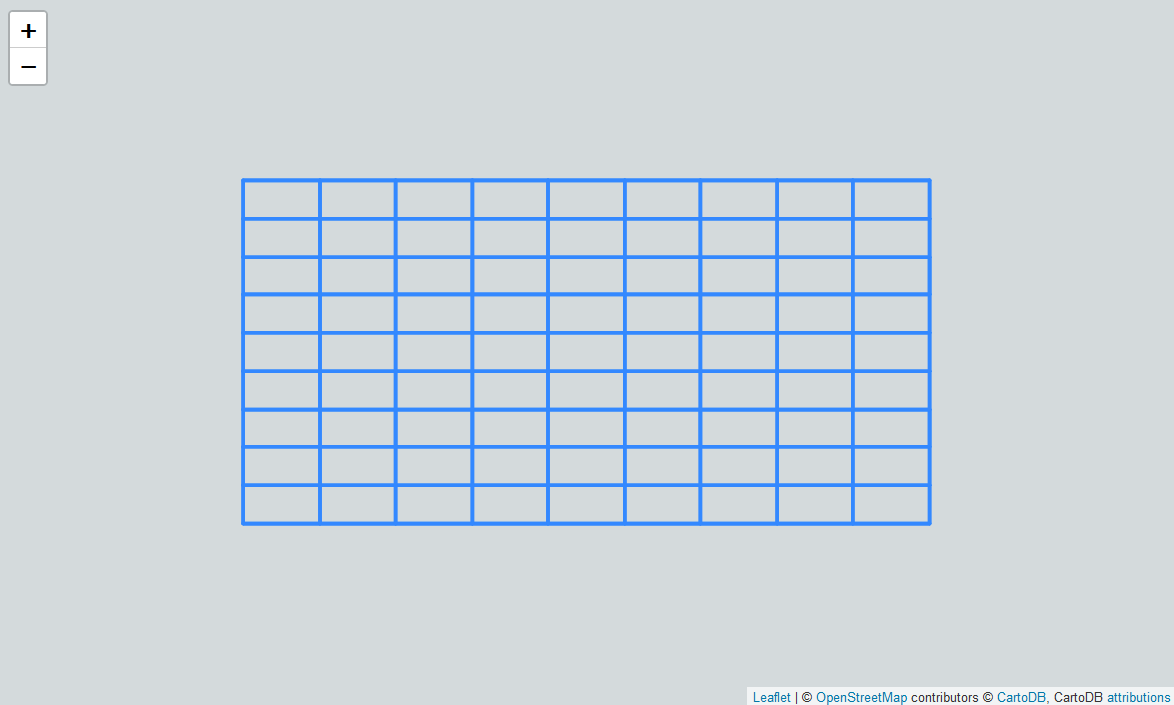